# Assignment 2 - Analysing and plotting the Pressure variation v/s Axial Distance with several temperature gradients.

## **Step 1**: Importing necessary libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np

## **Step 2**: Defining all the required constants.

In [2]:
GAMMA = 1.4       # specific heat capacity.
DX = 0.1          # Small section width
P_INITIAL = 2000  # P_bar at x=0
R = 287.2         # Gas constant of Dry Air (N2 + O2 + Other gases)
L = 4.0           # Lenght of the tube

## **Step 3**: Defining temperature profile functions

In [3]:
def create_temperature_profile(index):
    """
    This function will help us in creating a temperature profile based on the given index.

    The arguments include:
    1) index (int): Index to select temperature and gradient.

    It returns:
    1) function: Temperature profile function.
    2) str: Description of the temperature profile.
    """
    base_temps = [300, 500, 700, 900, 1100]
    temp_gradients = [-0, -50, -100, -150, -200] # we have taken this data from the table in research paper by Prof R.I Sujith and his colleagues

    T_base = base_temps[index]
    gradient = temp_gradients[index]

    def temp_profile(x):
        return T_base + gradient * x

    return temp_profile, f"T(x) = {T_base} {gradient:+}x"

## **Step 4**: Defining the peak counting function

In [5]:
def identify_pressure_peaks(pressure_array):
    """
    This helps us to count the number of pressure peaks in the array.

    Arguments here include:
    1) pressure_array (np.array): Array of pressure values.

    Things that it returns:
    1) int: Number of peaks.
    2) list: Indices of peaks.

    """
    peak_threshold = P_INITIAL * 0.5
    peak_indices = []
    for i in range(1, len(pressure_array) - 1):
        if (pressure_array[i] > pressure_array[i-1] and pressure_array[i] > pressure_array[i+1] and pressure_array[i] > peak_threshold):
            peak_indices.append(i)
    return len(peak_indices), peak_indices

## **Step 5**: Defining the Ordinary Differential Equation System

In [6]:
def acoustic_ode_system(x_idx, state, omega, temp_array, num_steps):
    """
    Define the ODE system for acoustic wave propagation.

    Args:
    x_idx (int): Current index in the spatial discretization.
    state (np.array): Current state [P, Z].
    omega (float): Angular frequency.
    temp_array (np.array): Array of temperature values.
    num_steps (int): Total number of steps.

    Returns:
    np.array: Derivatives [dP/dx, dZ/dx].
    """
    P, Z = state
    current_temp = temp_array[x_idx]

    if x_idx < num_steps:
        temp_gradient = (temp_array[x_idx + 1] - temp_array[x_idx]) / DX
    else:
        temp_gradient = (temp_array[x_idx] - temp_array[x_idx - 1]) / DX

    current_sound_speed = np.sqrt(GAMMA * R * current_temp)
    dZdx = -(temp_gradient / current_temp) * Z - (omega**2) / (current_sound_speed**2) * P
    dPdx = Z
    return np.array([dPdx, dZdx])

## **Step 6**: Defining the Mode solving function

In [7]:
def solve_acoustic_mode(target_mode, temp_profile):
    """
    Solve for a specific acoustic mode.

    Args:
    target_mode (int): The mode number to solve for.
    temp_profile (function): Temperature profile function.

    Returns:
    tuple: x, P, Z, omega, P4, num_peaks
    """
    x = np.arange(0, L + DX, DX)
    num_steps = len(x) - 1

    temp_array = np.array([temp_profile(pos) for pos in x])
    sound_speed_array = np.sqrt(GAMMA * R * temp_array)

    avg_sound_speed = np.mean(sound_speed_array)

    if target_mode == 0:
        omega_guess = 0.1 * np.pi * avg_sound_speed / L
        omega_range = np.linspace(0.01 * omega_guess, 10 * omega_guess, 300)
    else:
        omega_guess = target_mode * np.pi * avg_sound_speed / L
        omega_range = np.linspace(0.5 * omega_guess, 2.0 * omega_guess, 300)

    results = []

    for omega in omega_range:
        state = np.array([P_INITIAL, 0.0])
        P_solution = [state[0]]
        Z_solution = [state[1]]

        for step in range(num_steps):
            k1 = acoustic_ode_system(step, state, omega, temp_array, num_steps)
            k2 = acoustic_ode_system(step, state + DX/2 * k1, omega, temp_array, num_steps)
            k3 = acoustic_ode_system(step, state + DX/2 * k2, omega, temp_array, num_steps)
            k4 = acoustic_ode_system(step, state + DX * k3, omega, temp_array, num_steps)
            state += DX/6 * (k1 + 2*k2 + 2*k3 + k4)
            P_solution.append(state[0])
            Z_solution.append(state[1])

        P4 = state[0]
        abs_P = np.abs(P_solution)
        num_peaks, peak_indices = identify_pressure_peaks(abs_P)

        results.append((omega, P4, P_solution, Z_solution, num_peaks, peak_indices))

    if target_mode == 0:
        mode_solutions = [r for r in results if r[4] == 0]
    else:
        mode_solutions = [r for r in results if r[4] == target_mode]

    if not mode_solutions:
        best_idx = np.argmin(np.abs(np.array([res[1] for res in results])))
        best_omega, best_P4, best_P, best_Z, num_peaks, peak_indices = results[best_idx]
    else:
        best_idx = np.argmin(np.abs(np.array([res[1] for res in mode_solutions])))
        best_omega, best_P4, best_P, best_Z, num_peaks, peak_indices = mode_solutions[best_idx]

    return x, best_P, best_Z, best_omega, best_P4, num_peaks

## **Step 7:** The main execution loop

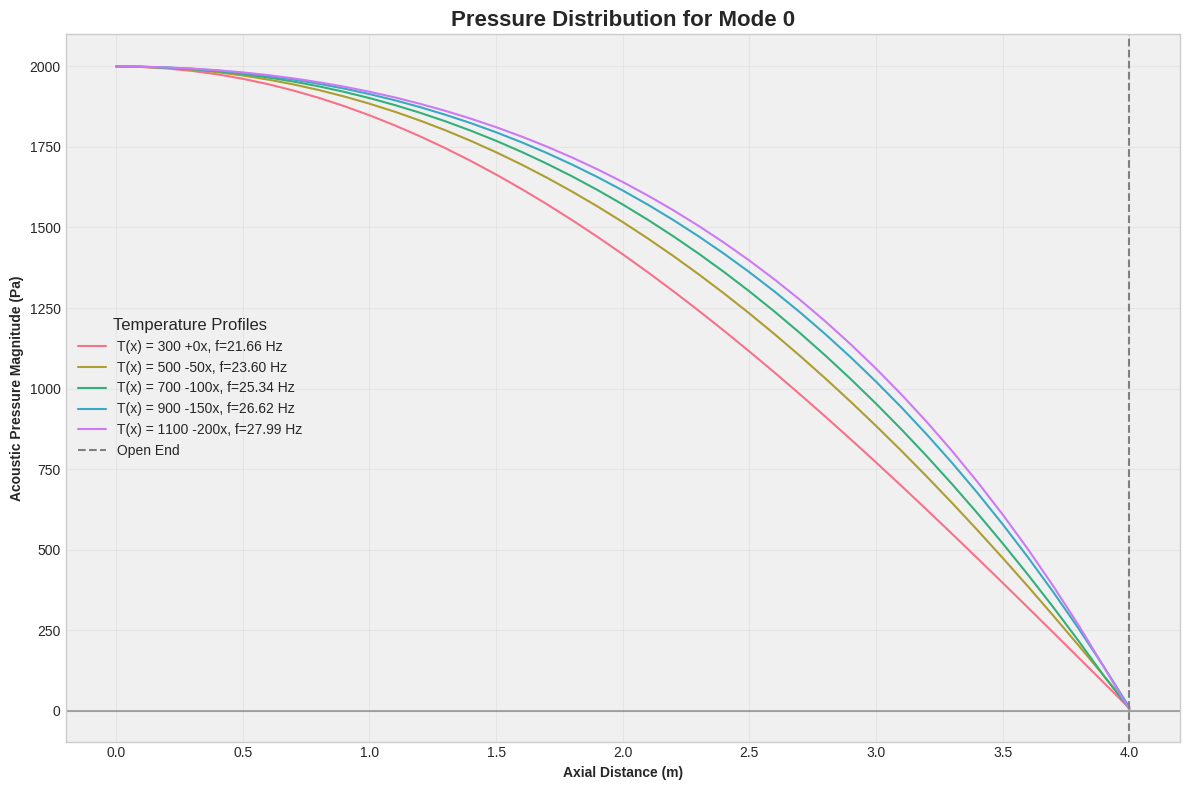


Frequency analysis for acoustic mode n=0:
Temperature Profile  Frequency (Hz)  Number of Peaks
------------------------------------------------------------
T(x) = 300 +0x       21.66           0              
T(x) = 500 -50x      23.60           0              
T(x) = 700 -100x     25.34           0              
T(x) = 900 -150x     26.62           0              
T(x) = 1100 -200x    27.99           0              


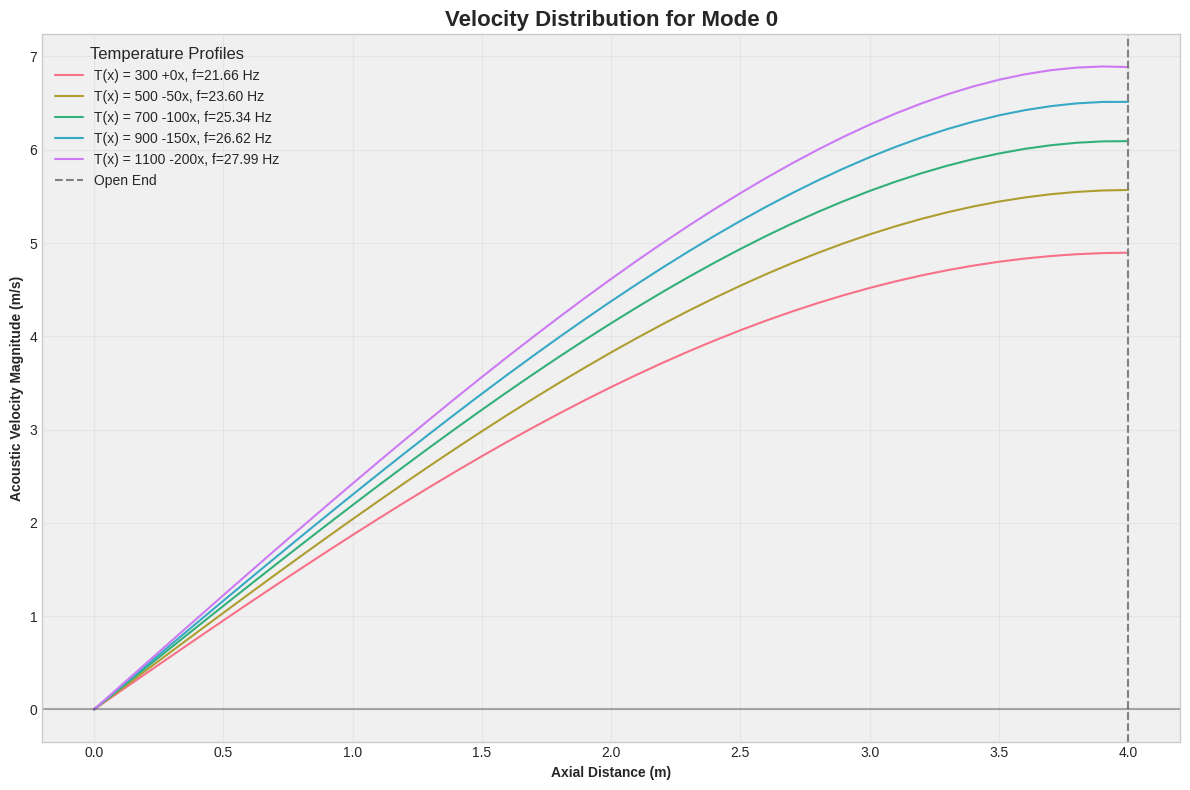

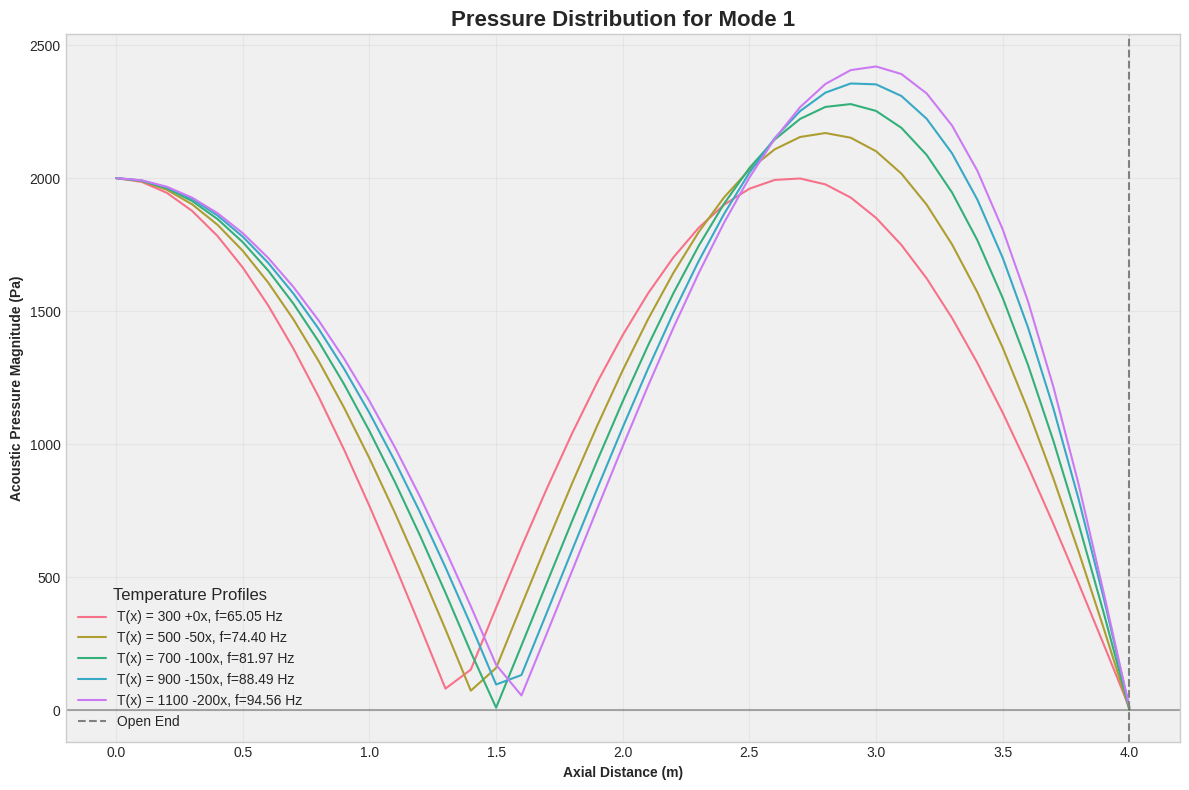


Frequency analysis for acoustic mode n=1:
Temperature Profile  Frequency (Hz)  Number of Peaks
------------------------------------------------------------
T(x) = 300 +0x       65.05           1              
T(x) = 500 -50x      74.40           1              
T(x) = 700 -100x     81.97           1              
T(x) = 900 -150x     88.49           1              
T(x) = 1100 -200x    94.56           1              


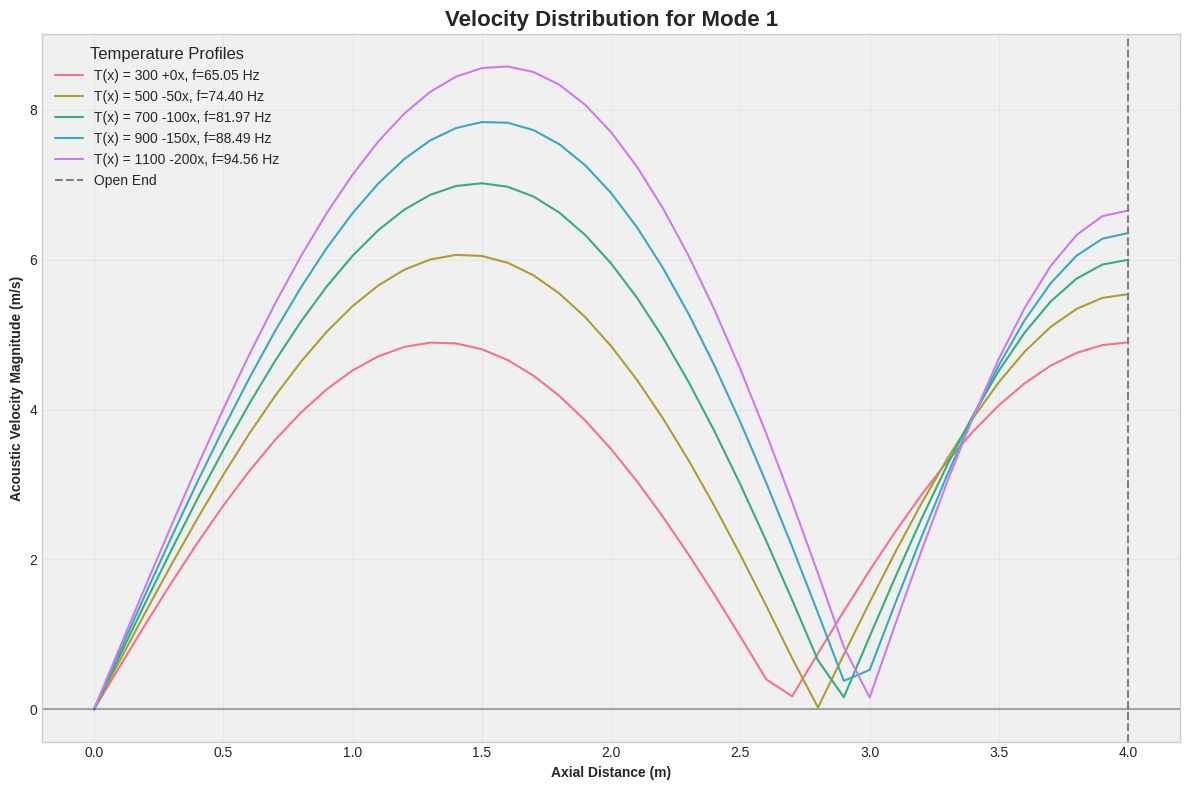

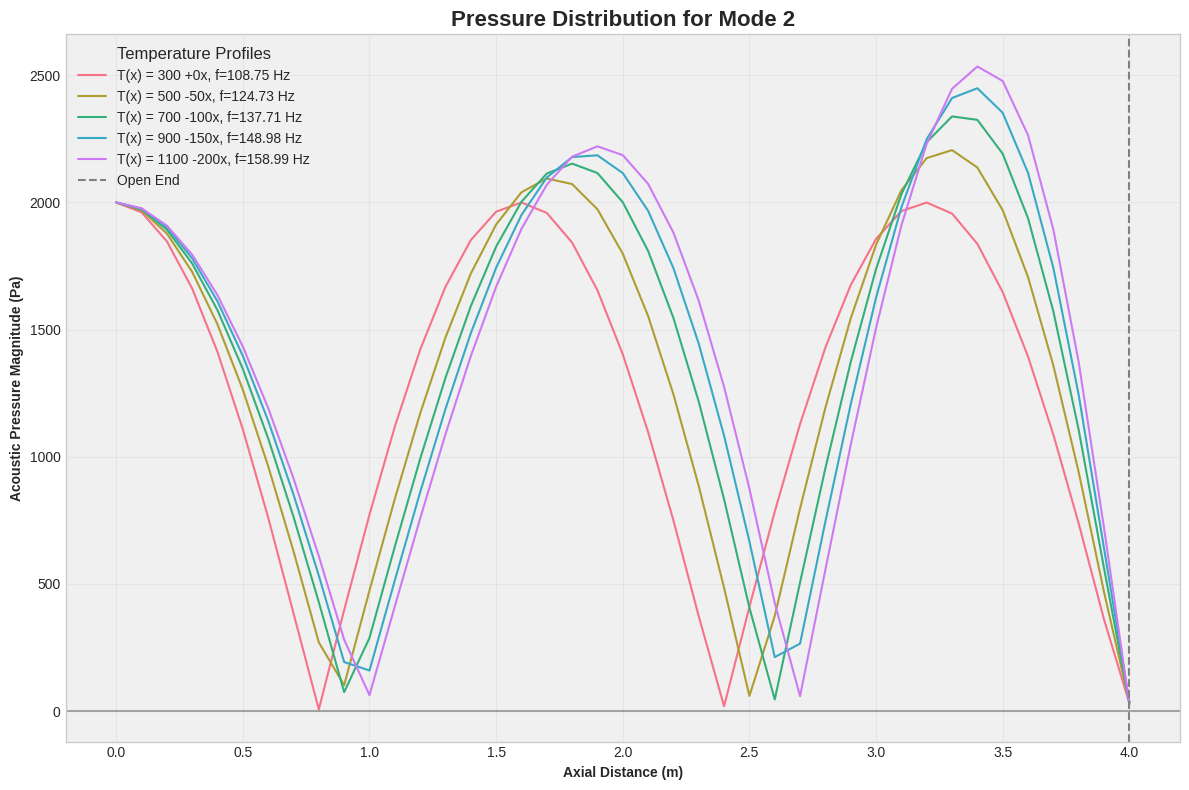


Frequency analysis for acoustic mode n=2:
Temperature Profile  Frequency (Hz)  Number of Peaks
------------------------------------------------------------
T(x) = 300 +0x       108.75          2              
T(x) = 500 -50x      124.73          2              
T(x) = 700 -100x     137.71          2              
T(x) = 900 -150x     148.98          2              
T(x) = 1100 -200x    158.99          2              


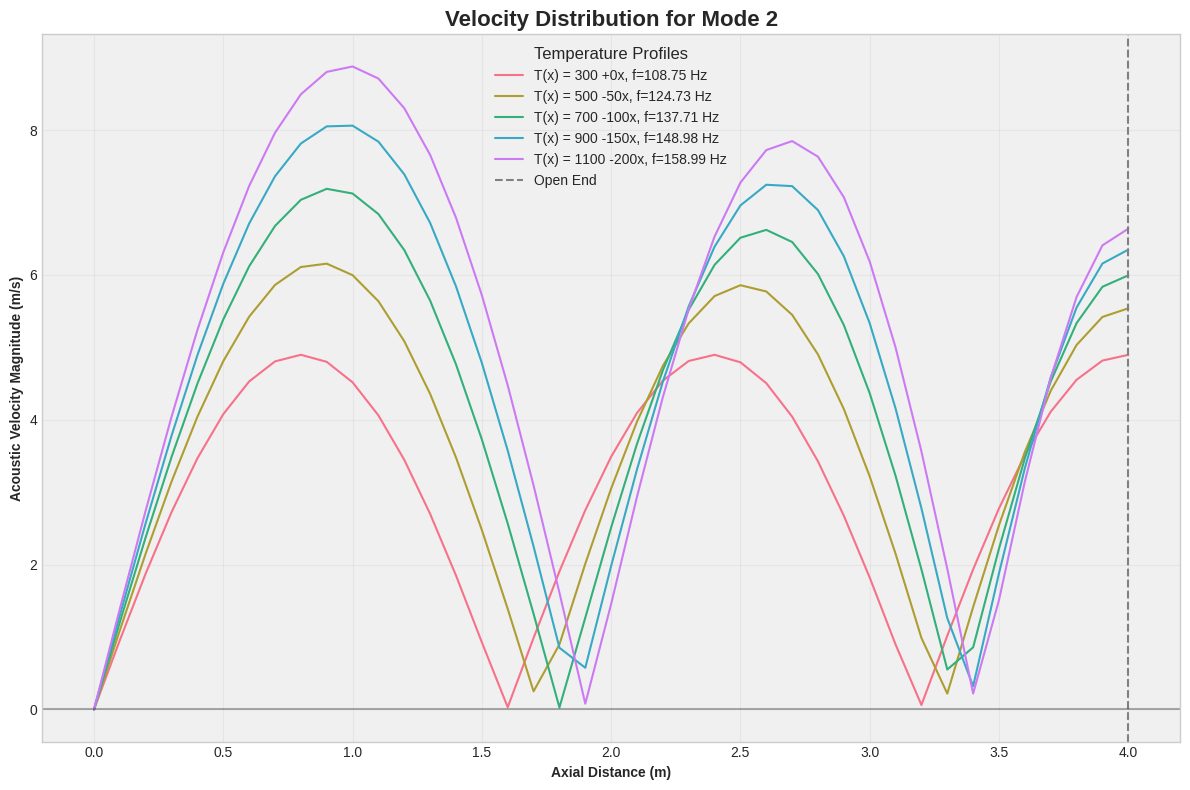

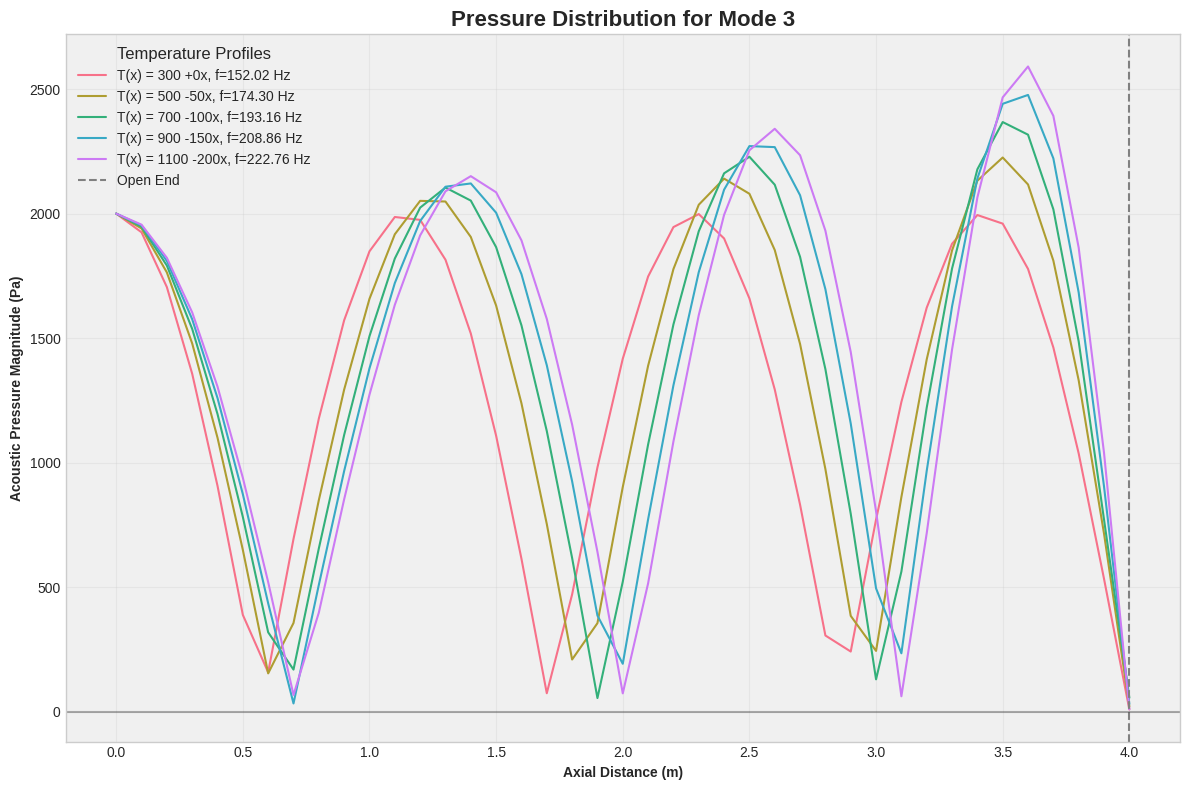


Frequency analysis for acoustic mode n=3:
Temperature Profile  Frequency (Hz)  Number of Peaks
------------------------------------------------------------
T(x) = 300 +0x       152.02          3              
T(x) = 500 -50x      174.30          3              
T(x) = 700 -100x     193.16          3              
T(x) = 900 -150x     208.86          3              
T(x) = 1100 -200x    222.76          3              


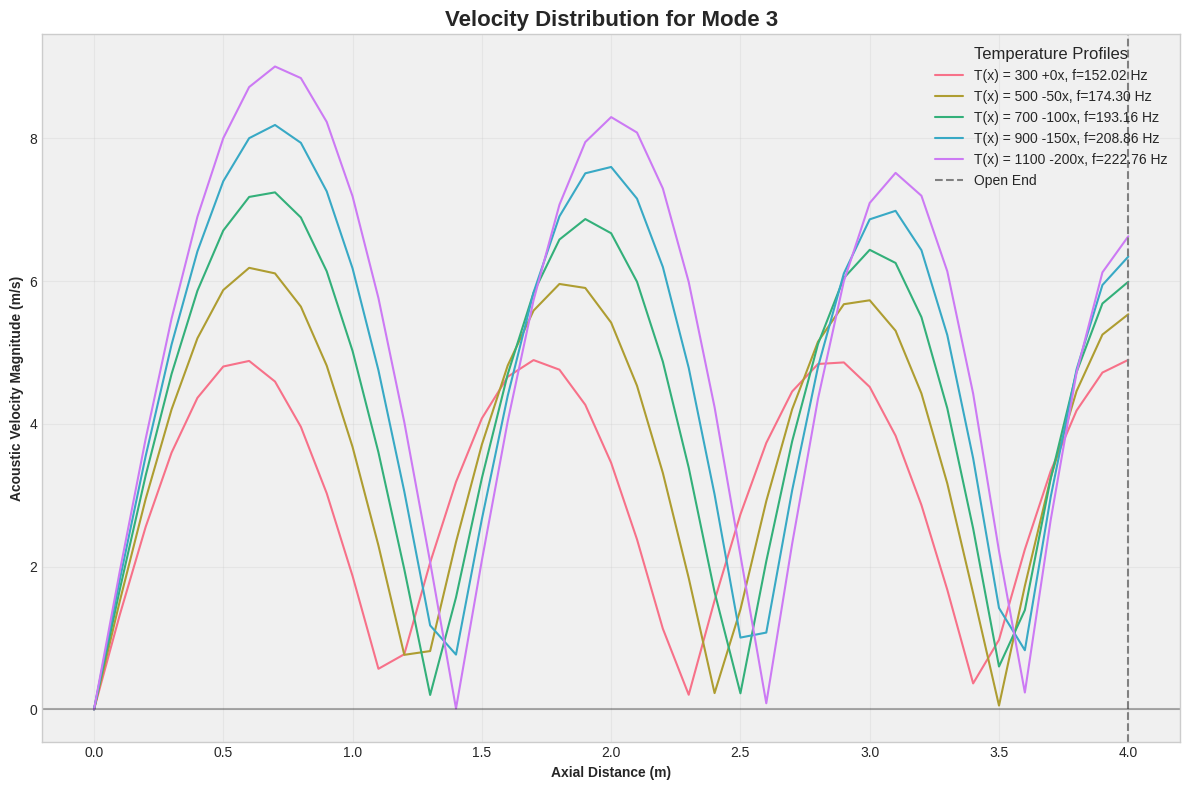

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a custom color palette
colors = sns.color_palette("husl", 5)

for target_mode in [0, 1, 2, 3]:
    frequency_results = []

    plt.figure(figsize=(12, 8))
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams['axes.facecolor'] = '#f0f0f0'

    for i in range(5):
        temp_profile, label = create_temperature_profile(i)

        x, P, Z, omega, P4, num_peaks = solve_acoustic_mode(target_mode, temp_profile)

        P_abs = np.abs(P)

        plt.plot(x, P_abs, label=f'{label}, f={omega/(2*np.pi):.2f} Hz', color=colors[i])
        frequency_results.append((label, omega, num_peaks))

    plt.xlabel('Axial Distance (m)', fontweight='bold')
    plt.ylabel('Acoustic Pressure Magnitude (Pa)', fontweight='bold')
    plt.axvline(x=4, color='gray', linestyle='--', label='Open End')
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.legend(title='Temperature Profiles', title_fontsize='12', fontsize='10')
    plt.grid(True, alpha=0.3)
    plt.title(f'Pressure Distribution for Mode {target_mode}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'mode_{target_mode}_pressure_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"\nFrequency analysis for acoustic mode n={target_mode}:")
    print("=" * 60)
    print(f"{'Temperature Profile':<20} {'Frequency (Hz)':<15} {'Number of Peaks':<15}")
    print("-" * 60)
    for label, omega, num_peaks in frequency_results:
        print(f"{label:<20} {omega/(2*np.pi):<15.2f} {num_peaks:<15}")
    print("=" * 60)

    plt.figure(figsize=(12, 8))
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams['axes.facecolor'] = '#f0f0f0'

    for i in range(5):
        temp_profile, label = create_temperature_profile(i)

        x, P, Z, omega, P4, num_peaks = solve_acoustic_mode(target_mode, temp_profile)

        temp_array = np.array([temp_profile(pos) for pos in x])

        P_mean = 101325
        density = P_mean / (R * temp_array)

        velocity_amplitude = np.abs(-1 / (omega * density) * np.array(Z))

        plt.plot(x, velocity_amplitude, label=f'{label}, f={omega/(2*np.pi):.2f} Hz', color=colors[i])

    plt.xlabel('Axial Distance (m)', fontweight='bold')
    plt.ylabel('Acoustic Velocity Magnitude (m/s)', fontweight='bold')
    plt.axvline(x=4, color='gray', linestyle='--', label='Open End')
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.legend(title='Temperature Profiles', title_fontsize='12', fontsize='10')
    plt.grid(True, alpha=0.3)
    plt.title(f'Velocity Distribution for Mode {target_mode}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'mode_{target_mode}_velocity_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()